# Plot regression R2 scores and coefficients

After fitting regression models to the spectral power at each ECoG electrode, we can plot the R2 scores fit to withheld data (including delta R^2 scores that indicate the importance of each feature), along with coefficient values. Note that these values are averaged across all permutations of train/test splits. This notebook will generate Fig. 6 from the paper.

In [1]:
%matplotlib inline
import natsort,glob
import numpy as np
import pandas as pd
from mne.time_frequency import read_tfrs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize,LinearSegmentedColormap
from matplotlib import gridspec
from tqdm import tqdm_notebook as tqdm
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

#Custom packages
import config
from tfr_utils import plot_ecog_electrodes_mni_in_order,add_colorbar
from regression_utils import compute_r2_score_colors,compute_reg_coef_colors,compute_ind_subj_r2_colors

### Set parameters

In [2]:
reg_lp = '.../data_release/naturalistic_reaches/tfr/regressions_sameband/'
tfr_lp = '.../data_release/naturalistic_reaches/tfr/'
plot_sd_coef = False #whether to plot coefficient SD (True) or mean (False) across permutations

#Load config parameters
r2_thresh = config.constants_regress['r2_thresh'] #threshold for well-fit models
chan_labels = config.constants_regress['chan_labels'] #decide which electrodes to plot ('allgood' means plot only marked good electrodes)
vscale_r2 = config.constants_regress['vscale_r2']

r2_plt_titles = config.constants_regress['r2_plt_titles']
coef_plt_titles = config.constants_regress['coef_plt_titles']
zero_rem_thresh = config.constants_regress['zero_rem_thresh']

if plot_sd_coef:
    vscale_coef = config.constants_regress['vscale_coef_sd']
else:
    vscale_coef = config.constants_regress['vscale_coef']

### Load in regression results

In [3]:
suff = '_v5' # '_daycov', ''
reg_coefs = np.load(reg_lp+'reg_coefs'+suff+'.npy')
reg_r2_train = np.load(reg_lp+'reg_r2_train'+suff+'.npy')
reg_r2_test = np.load(reg_lp+'reg_r2_test'+suff+'.npy')
del_r2_train = np.load(reg_lp+'del_r2_train'+suff+'.npy')
del_r2_test = np.load(reg_lp+'del_r2_test'+suff+'.npy')
n_subjs,max_chan_num,n_coefs,n_freqs,n_perms = reg_coefs.shape

#Compute measures for plotting
#1) This should be average (used for deciding which electrodes to plot)
reg_r2_test_ave = np.mean(reg_r2_test,axis=-1)

#2) These are the values to be plotted (can be average or variance measure)
r2_dat_plot = np.mean(reg_r2_test,axis=-1)
del_r2_dat_plot = np.mean(del_r2_test,axis=-1)
if plot_sd_coef:
    reg_coefs_dat_plot = np.std(reg_coefs,axis=-1)
else:
    reg_coefs_dat_plot = np.mean(reg_coefs,axis=-1)

### Find number of electrodes per subject with positive R2 scores

In [4]:
lo_band,hi_band,elec_locs,bad_chans_all = [],[],[],[]
for i in range(n_subjs):
    fname_tfr = natsort.natsorted(glob.glob(tfr_lp+'subj_'+str(i+1).zfill(2)+'*.h5'))[-1]
    power = read_tfrs(fname_tfr)[0]
    bad_chans = power.info['bads']
    ch_list = np.asarray(power.info['ch_names'])
    
    #Save electrode locations
    elec_locs_temp = np.zeros([len(power.info['chs']),3])
    for k in range(len(power.info['chs'])):
        elec_locs_temp[k,:] = power.info['chs'][k]['loc'][:3]
    elec_locs.append(elec_locs_temp)
        
    inds2drop = []
    for bad_ch in bad_chans:
        inds2drop.append(np.nonzero(ch_list==bad_ch)[0][0])
        
    inds2drop = np.asarray(inds2drop)
    bad_chans_all.append(inds2drop)
    good_chans = np.setdiff1d(np.arange(len(ch_list)),inds2drop)
    lo_band.append(len(np.nonzero(reg_r2_test_ave[i,good_chans,0]>r2_thresh)[0]))
    hi_band.append(len(np.nonzero(reg_r2_test_ave[i,good_chans,1]>r2_thresh)[0]))

Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_01_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_02_day_6_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_03_day_6_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_04_day_7_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_05_day_7_l_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_06_day_7_r_allEpochs_tfr.h5 ...
Adding metadata with 21 columns
Reading /data1/users/stepeter/mvmt_init/data_release/naturalistic_reaches/tfr/subj_07_day_7_l_allEpochs_tfr.h5 ...
Add

### Plot regression results

/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/stepeter/anaconda3/envs/tf/lib/python3.8/site-packages/numpy/core/_methods.py:1

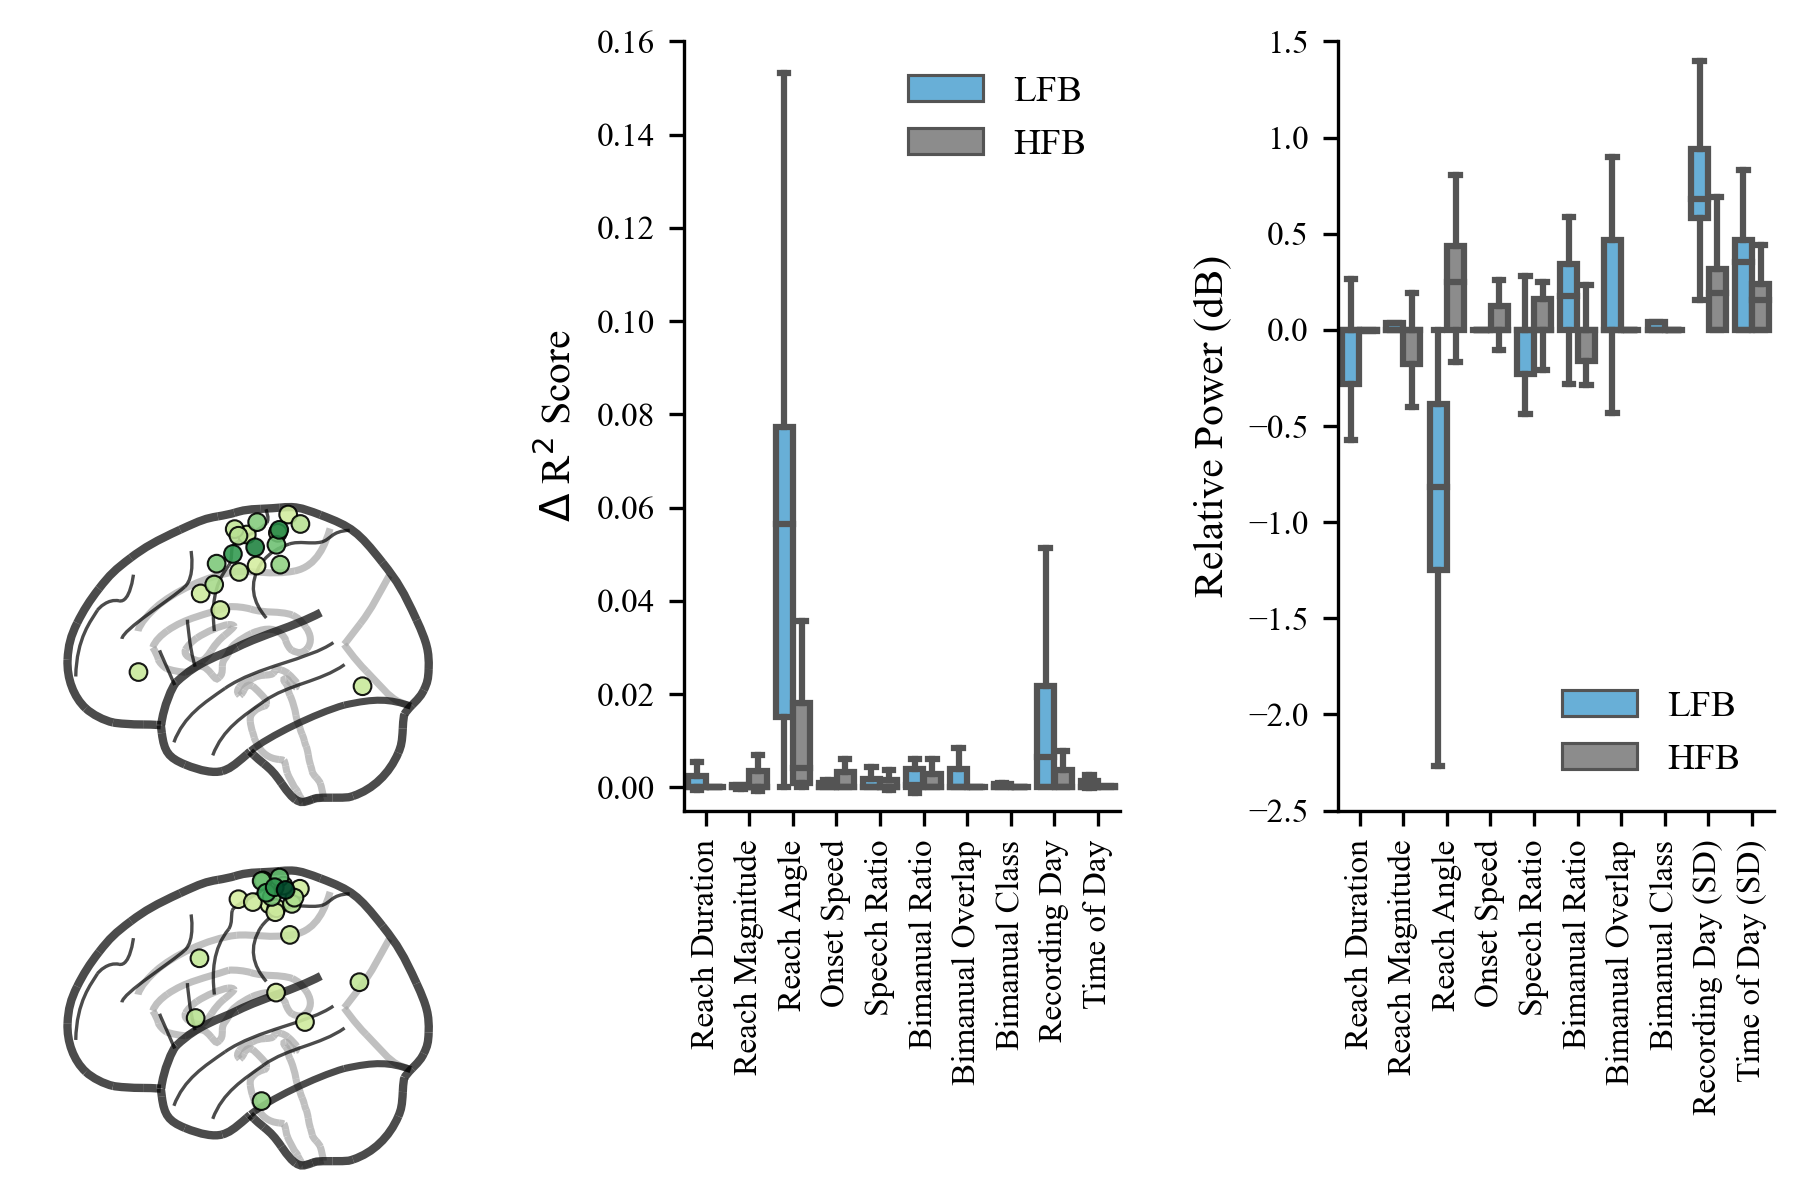

In [5]:
dpi_plt = 300
nrows, ncols = 3, 3
freq_labels = ['LFB','HFB']
my_pal = [sns.color_palette('colorblind')[9]]+[sns.color_palette('deep')[7]]
fig = plt.figure(dpi=dpi_plt,figsize=(7.5,5))
gs = gridspec.GridSpec(nrows=nrows,ncols=ncols,figure=fig,width_ratios= [1]*ncols,
                       height_ratios= [1.3,1,1],wspace=.5, hspace=.15)
ax = [None]*4

# reg_r2_test_ave[reg_r2_test_ave<r2_thresh] = -.1
# r2_dat_plot[r2_dat_plot<r2_thresh] = -.1
colors_all_r2_feats,colors_all_r2,vals_all_r2imp,cmap_r2 = compute_r2_score_colors(r2_dat_plot,del_r2_dat_plot,n_subjs,
                                                                                   n_freqs,n_coefs,reg_r2_test_ave,
                                                                                   r2_thresh,vmax=config.constants_regress['vscale_r2'][1])
rem_zero_chans = True
for j in range(n_freqs):
    ax[j] = fig.add_subplot(gs[j+1,0])
    plot_ecog_electrodes_mni_in_order(elec_locs,bad_chans_all,chan_labels,num_grid_chans=64,node_size=18,
                                      colors_in=colors_all_r2[:,j],
                                      elec_col_suppl_in=colors_all_r2_feats[:,j,0],alpha=.9,sides_2_display='l',
                                      node_edge_colors='k',edge_linewidths=.5,ax_in=ax[j],
                                      rem_zero_chans=rem_zero_chans,zero_rem_thresh=zero_rem_thresh,
                                      allLH=True,sort_vals_in = vals_all_r2imp[:,j,0],sort_abs=True)
#     ax[j].set_title(freq_labels[j],fontsize=10,fontstyle='italic')

num_freqs = reg_r2_test_ave.shape[-1]
pos_r2_inds = np.nonzero(reg_r2_test_ave[...,0]>0.05)

meas_lst, r2_vals_lst, freq_lst = [], [], []
for freq_ind in range(num_freqs):
    for i in range(del_r2_dat_plot.shape[2]):
        for j in range(len(pos_r2_inds[0])):
            curr_meas = r2_plt_titles[i+1]
            curr_meas = curr_meas.replace('\n',' ')
            curr_meas = " ".join([word.capitalize()
                                  for word in curr_meas.split(" ")
                                  ])
            if curr_meas=='Time Of Day':
                curr_meas = 'Time of Day'
            elif curr_meas=='Day':
                curr_meas = 'Recording Day'
            elif curr_meas=='Onset Velocity':
                curr_meas = 'Onset Speed'
            elif curr_meas=='Audio Ratio':
                curr_meas = 'Speech Ratio'
            elif curr_meas=='Bimanual Lag':
                curr_meas = 'Bimanual Overlap'
            elif curr_meas=='Bimanual':
                curr_meas = 'Bimanual Class'
            
            meas_lst.append(curr_meas)
            r2_vals_lst.append(del_r2_dat_plot[pos_r2_inds[0][j],pos_r2_inds[1][j],i,freq_ind])
            freq_lst.append(freq_labels[freq_ind])
            
df_plt_r2 = pd.DataFrame(list(zip(r2_vals_lst,meas_lst,freq_lst)),columns=['R2 Score','Feature','Freq_band'])

ax[2] = fig.add_subplot(gs[:2,1])
sns.boxplot(data=df_plt_r2,x='Feature',y='R2 Score',hue='Freq_band',showfliers=False,ax=ax[2],palette=my_pal)
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation = 90, ha="center")
ax[2].set_ylabel(r'$\Delta$ R$^2$ Score')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
ax[2].set_ylim([-.005,.16])
ax[2].tick_params(axis='both', labelsize=8)
ax[2].set_xlabel('')
ax[2].legend(loc='upper right',frameon=False, prop={'size': 9})
# ax[2].set_title('(C) Feature importance')


num_freqs = reg_r2_test_ave.shape[-1]
freq_labels = ['LFB','HFB']
pos_r2_inds = np.nonzero(reg_r2_test_ave[...,0]>0.05)

meas_lst, r2_vals_lst, freq_lst = [], [], []
for freq_ind in range(num_freqs):
    for i in range(reg_coefs_dat_plot.shape[2]-1):
        for j in range(len(pos_r2_inds[0])):
            curr_meas = r2_plt_titles[i+1]
            curr_meas = curr_meas.replace('\n',' ')
            curr_meas = " ".join([word.capitalize()
                                  for word in curr_meas.split(" ")
                                  ])
            if (curr_meas=='Day'):
                curr_meas = 'Recording Day (SD)'
            elif curr_meas=='Time Of Day':
                curr_meas = 'Time of Day (SD)'
            elif curr_meas=='Onset Velocity':
                curr_meas = 'Onset Speed'
            elif curr_meas=='Audio Ratio':
                curr_meas = 'Speech Ratio'
            elif curr_meas=='Bimanual Lag':
                curr_meas = 'Bimanual Overlap'
            elif curr_meas=='Bimanual':
                curr_meas = 'Bimanual Class'
            meas_lst.append(curr_meas)
            r2_vals_lst.append(reg_coefs_dat_plot[pos_r2_inds[0][j],pos_r2_inds[1][j],i+1,freq_ind])
            freq_lst.append(freq_labels[freq_ind])
            
df_plt_coef = pd.DataFrame(list(zip(r2_vals_lst,meas_lst,freq_lst)),columns=['Relative Power (dB)','Feature','Freq_band'])

ax[3] = fig.add_subplot(gs[:2,2])
sns.boxplot(data=df_plt_coef,x='Feature',y='Relative Power (dB)',hue='Freq_band',showfliers=False,ax=ax[3],palette=my_pal)
ax[3].set_xticklabels(ax[3].get_xticklabels(), rotation = 90, ha="center")
ax[3].spines['right'].set_visible(False)
ax[3].spines['top'].set_visible(False)
ax[3].tick_params(axis='both', labelsize=8)
ax[3].set_xlabel('')
ax[3].set_ylim([-2.5,1.5])
ax[3].legend(loc='lower right',frameon=False, prop={'size': 9})
# ax[3].set_title('(D) Coefficient values')

# Save figure
fig_sp = '/data1/users/stepeter/mvmt_init/figs/'
fig_name = 'main_reg_output_v2'
# fig.savefig(fig_sp+fig_name+'.png',
#             format='png',  transparent= True,dpi=dpi_plt,
#             bbox_inches = 'tight', pad_inches = 0.01,
#             )
plt.show()